# Confidence Progress

So, I've tried several methods to try to get a method that, for the most part, weeds out the spectra that are just noise. Most of the methods were just random nonsense but I ended up with four that had varying levels of success:
* Kevin's method (which I think is the best method but it doesn't seem to be capturing enough emission spectra, so I'm thinking it will be good as one of the checks)
* Using the Ebbets paper to get $\sigma_w$, the standard deviation of the emission feature itself (which uses SNR!)
* Comparing the mean of the line (where the emission feature should be) to the mean of the continuum windows (the continuum calculation already done)
* The latest method I've devised is a little interesting (to me at least). This method is to compare the pseudo-area above the continuum line to that below it. This has been the most successful so far as there is a distinct threshold where ** *all* ** the spectra are emission features. However, below this is gets murky and captures alot of the noise spectra. I'll detail how this works below.

First, we import all the necessary packages...

In [1]:
%run ../Modules/Importing.py

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

And a quick aside, I've changed the continuum windows to be larger because absorbtion features were lowering the continuum line and causing calculations to be off. So, by widening the windows we can get a better estimation of the continuum line and also reduces the error in calculating it.

Below I've put an example of a spectra with an absorbtion feature in the continuum windows and the new continuum window widths. The windows have been increased by ~25% and are now (combined) as wide as the emission feature window.

In [3]:
filename = '6845-56745-290'
filepath1 = '/Users/ballanr/Desktop/File Outputs/Wave and Flux/'+filename+'.csv'

openfile = pd.read_csv(filepath1)

wave = openfile['Wavelength']
flux = openfile['Flux']

In [4]:
center = f.find_nearest(wave,16811.17934)

L1 = center - 301# ~ 56 Angstroms
L2 = center - 150 # ~ 35 Angstroms
R1 = center + 150
R2 = center + 301

linemean = np.mean(flux[L2:R1])
leftwindow = np.mean(flux[L1:L2])
rightwindow = np.mean(flux[R1:R2])
cmean = (0.5)*(leftwindow + rightwindow)

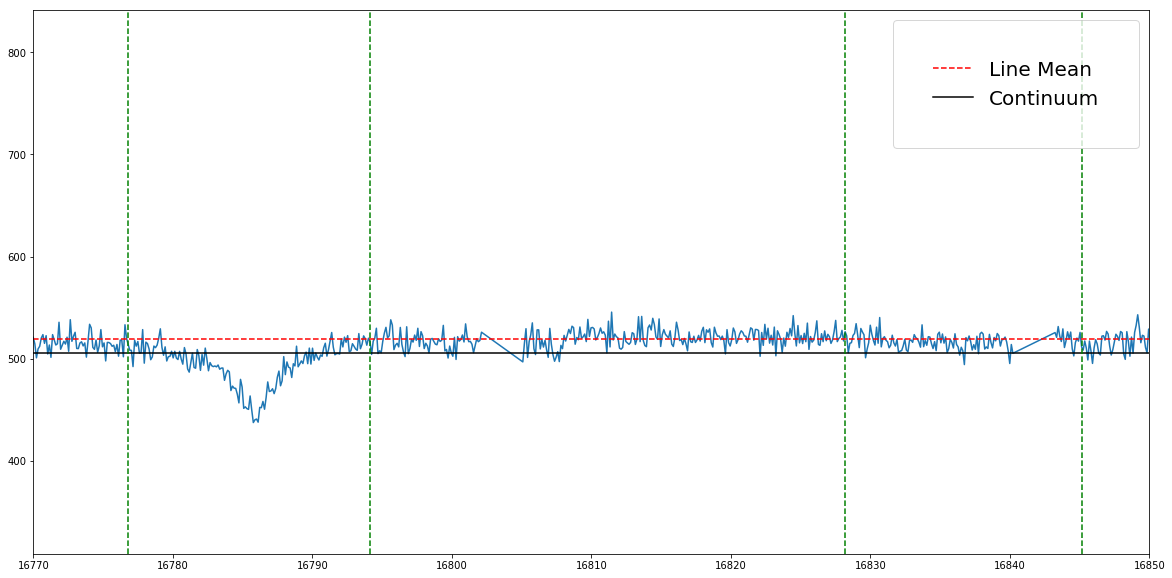

In [5]:
plt.figure(figsize=(20,10))
#plt.scatter(wave,flux,color='black',s=25);
plt.plot(wave,flux,label='_nolegend_');
plt.axhline(linemean,ls='dashed',color='red',label='Line Mean')
plt.axhline(cmean,ls='solid',color='black',label='Continuum')
plt.axvline(wave[L1],ls='dashed',color='green')
plt.axvline(wave[L2],ls='dashed',color='green')
plt.axvline(wave[R1],ls='dashed',color='green')
plt.axvline(wave[R2],ls='dashed',color='green')
plt.legend(loc = 'upper right',borderpad=2,fontsize=20)
#plt.ylim(100,200);
plt.xlim(16770,16850);

This spectra is just noise as there is no discernible peak but let's continue on with the calculation as it's a good example of a spectra that falls into the grey area of determining whether there is an emission feature or not.

In [6]:
abovex = []
abovey = []
belowx = []
belowy = []
for k in range(R1-L2):
    x = wave[L2 + k]
    y = flux[L2 + k]
    gy = y - cmean
    
    if gy > 0:
        abovex.append(x)
        abovey.append(y)
    else:
        belowx.append(x)
        belowy.append(y)

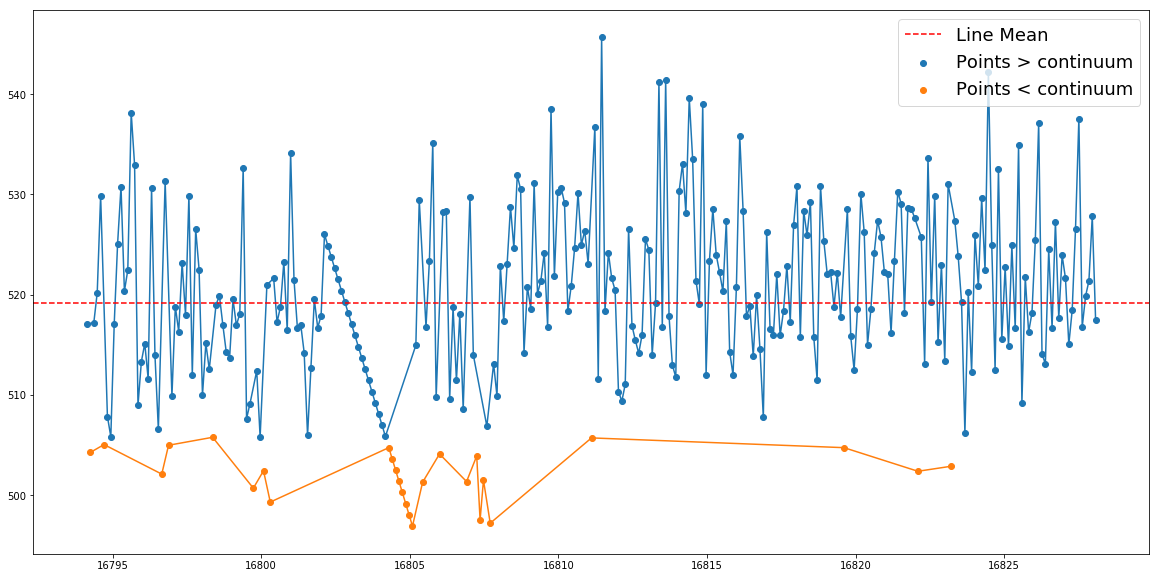

In [7]:
plt.figure(figsize=(20,10));
plt.plot(abovex,abovey);
plt.scatter(abovex,abovey,label='Points > continuum');
plt.plot(belowx,belowy);
plt.scatter(belowx,belowy,label='Points < continuum');
plt.axhline(linemean,ls='dashed',color='red',label='Line Mean');
plt.legend(loc='upper right',fontsize=18);

So what happened in the plot above is that I went through all the data points in the line window and sorted them into two new lists of whether or not a particular flux value was above the continuum or not. After I've sorted them I then calculate the area (using the trapezoid method) of both lists and then divide the upper area by the lower area.

If there are no flux values below the continuum then I just return the area above which will be large.

In [8]:
aboveArea = 0
belowArea = 0

for i in range(len(abovex)-1):

            trapezoid = (0.5)*(abovex[i+1] - abovex[i])*(abovey[i+1] + abovey[i] - (2*cmean))
            aboveArea += trapezoid

for j in range(len(belowx)-1):

            trapezoid1 = (0.5)*(belowx[j+1] - belowx[j])*(-belowy[j+1] - belowy[j] + (2*cmean))
            belowArea += trapezoid1

if belowArea != 0:
    arearatio = (aboveArea / belowArea)
else: 
    arearatio = aboveArea
arearatio,aboveArea,belowArea

(7.0554383906293996, 495.60947759031342, 70.24502945820511)

This particular example is one where we can visually see that it is just noise but the code sees it as having an area ratio of ~7. I've gone through several different chunks of all the visit files and have found emission features with an area ratio as low as ~2.8 so far. 

This spectra shows how an absorbtion feature (or emission) in the continuum window raises the continuum itself and throws off this calculation. Without the absorbtion feature I would expect the line window to be roughly symmetric around the continuum and thus return an area ratio between 0 and ~1.5.

Now, let's look at a nice emission feature.

In [9]:
filename = '5525-56472-255'
filepath2 = '/Users/ballanr/Desktop/File Outputs/Wave and Flux/'+filename+'.csv'

openfile = pd.read_csv(filepath2)

wave1 = openfile['Wavelength']
flux1 = openfile['Flux']

In [10]:
center1 = f.find_nearest(wave,16811.17934)

L1 = center1 - 301# ~ 56 Angstroms
L2 = center1 - 150 # ~ 35 Angstroms
R1 = center1 + 150
R2 = center1 + 301

linemean1 = np.mean(flux1[L2:R1])
leftwindow1 = np.mean(flux1[L1:L2])
rightwindow1 = np.mean(flux1[R1:R2])
cmean1 = (0.5)*(leftwindow1 + rightwindow1)

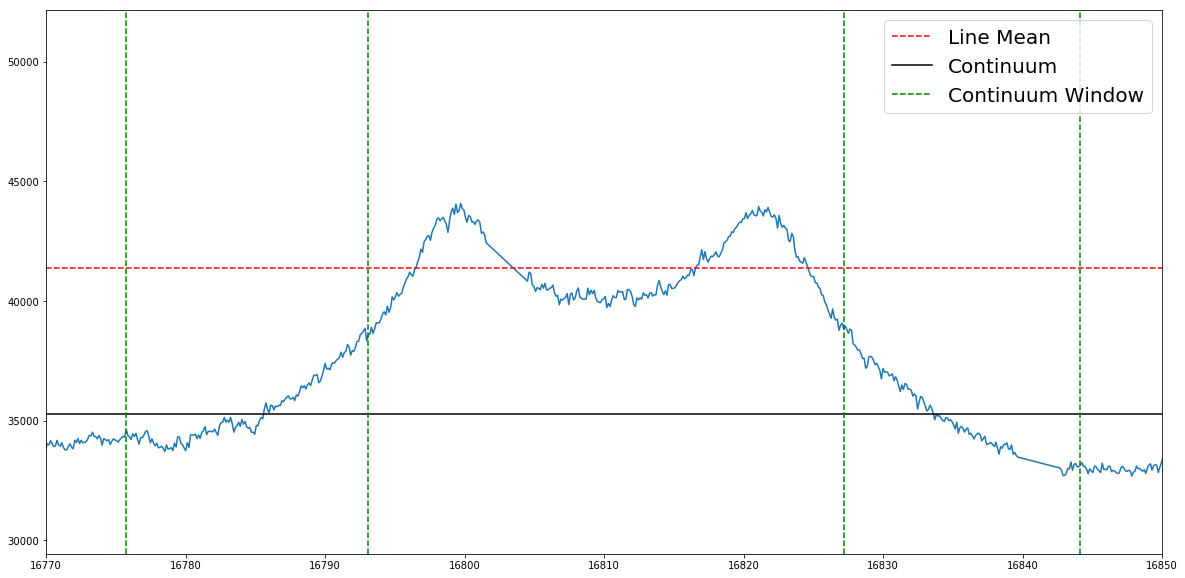

In [11]:
plt.figure(figsize=(20,10))
#plt.scatter(wave,flux,color='black',s=25);
plt.plot(wave1,flux1,label='_nolegend_');
plt.axhline(linemean1,ls='dashed',color='red',label='Line Mean')
plt.axhline(cmean1,ls='solid',color='black',label='Continuum')
plt.axvline(wave1[L1],ls='dashed',color='green',label='Continuum Window')
plt.axvline(wave1[L2],ls='dashed',color='green')
plt.axvline(wave1[R1],ls='dashed',color='green')
plt.axvline(wave1[R2],ls='dashed',color='green')
plt.legend(loc = 'upper right',fontsize=20)
#plt.ylim(100,200);
plt.xlim(16770,16850);

In [12]:
abovex1 = []
abovey1 = []
belowx1 = []
belowy1 = []
for k in range(R1-L2):
    x1 = wave1[L2 + k]
    y1 = flux1[L2 + k]
    gy1 = y1 - cmean1
    
    if gy1 > 0:
        abovex1.append(x1)
        abovey1.append(y1)
    else:
        belowx1.append(x1)
        belowy1.append(y1)

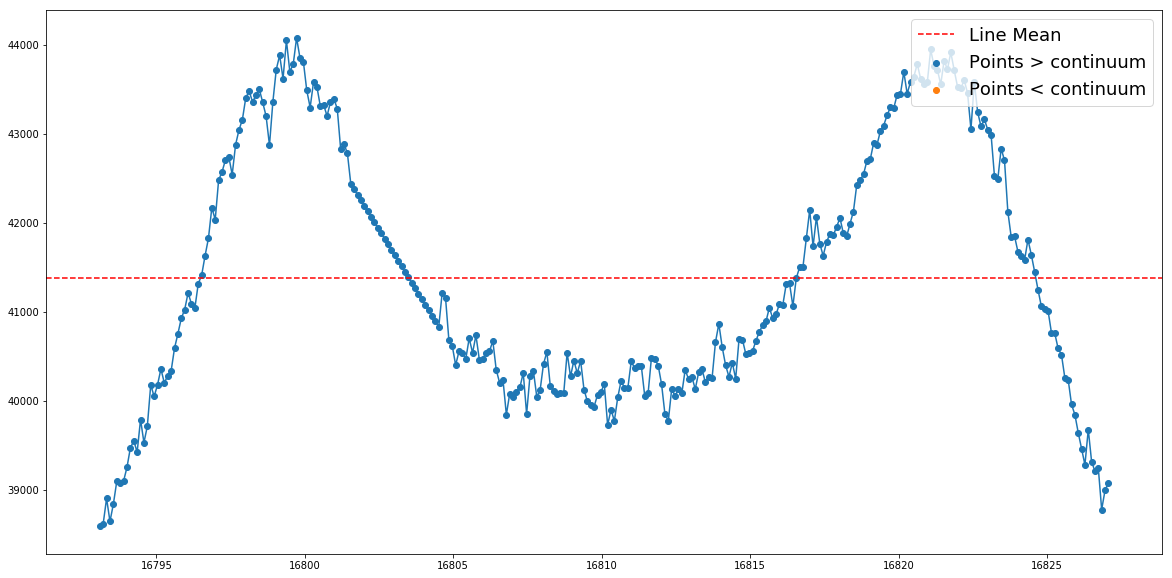

In [13]:
plt.figure(figsize=(20,10));
plt.plot(abovex1,abovey1);
plt.scatter(abovex1,abovey1,label='Points > continuum');
plt.plot(belowx1,belowy1);
plt.scatter(belowx1,belowy1,label='Points < continuum');
plt.axhline(linemean1,ls='dashed',color='red',label='Line Mean');
plt.legend(loc='upper right',fontsize=18);

In [14]:
aboveArea1 = 0
belowArea1 = 0

for i in range(len(abovex1)-1):

            trapezoid = (0.5)*(abovex1[i+1] - abovex1[i])*(abovey1[i+1] + abovey1[i] - (2*cmean1))
            aboveArea1 += trapezoid

for j in range(len(belowx1)-1):

            trapezoid1 = (0.5)*(belowx1[j+1] - belowx1[j])*(-belowy1[j+1] - belowy1[j] + (2*cmean1))
            belowArea1 += trapezoid1

if belowArea1 != 0:
    arearatio1 = (aboveArea1 / belowArea1)
else: 
    arearatio1 = aboveArea1
arearatio1,aboveArea1,belowArea1

(208095.76135821475, 208095.76135821475, 0)

When we have a emission feature we get very large values for the area ratio as there are usually very few to no flux values below the continuum. But, for an area ratio < ~10 things get a little harder to discern. 

Because of possible contamination in the continuum calculation by emission/absorbtion features I think that this method should be used in conjuction with another method (the one proposed by Kevin seems the best) to get rid of most noisy spectra.

## Histograms

Below are histograms from a data set of visually confirmed/rejected emission features plotted versus both sets together for three different tests. There are ~125 objects here. 

I feel like using the area ratios and kevin's method in tandem will give the best results. But, that may just be my bias since I like the area ratios method!

In [15]:
openfile = pd.read_csv('/Users/ballanr/Desktop/peakstocompare.csv')
zeros = pd.read_csv('/Users/ballanr/Desktop/peakstocompare0.csv')
ones = pd.read_csv('/Users/ballanr/Desktop/peakstocompare1.csv')

In [16]:
kevinsmethod = openfile['Confidence1']
kevinsmethod0 = zeros['Confidence1']
kevinsmethod1 = ones['Confidence1']
ebbets = openfile['Confidence2']
ebbets0 = zeros['Confidence2']
ebbets1 = ones['Confidence2']
Area = openfile['Area Ratios']
Area0 = zeros['Area Ratios']
Area1 = ones['Area Ratios']

In [17]:
km = []
a = []
area1 = []
for i in range(len(kevinsmethod)):
    if kevinsmethod[i] > 0 and kevinsmethod[i] < 15:
        km.append(kevinsmethod[i])
km = np.asarray(km)
for k in range(len(Area)):
    if Area[k] < 10:
        a.append(Area[k])
for j in range(len(Area1)):
    if Area1[j] < 10:
        area1.append(Area1[j])

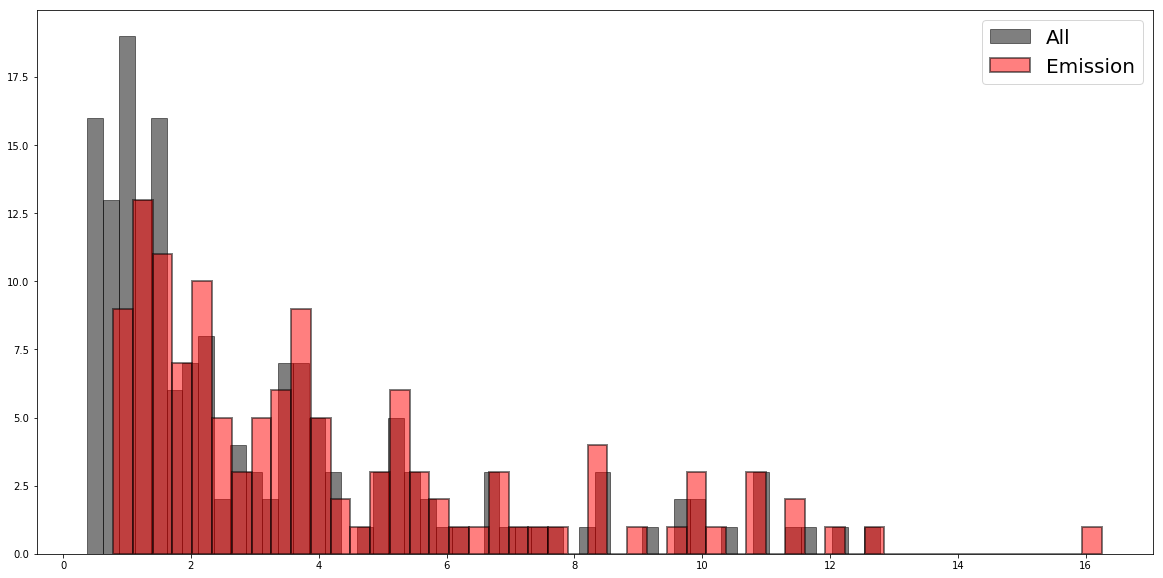

In [18]:
plt.figure(figsize=(20,10));
plt.hist(km,bins=50,color='black',alpha=0.5,edgecolor='black',label='All');
plt.hist(kevinsmethod1,bins=50,color='red',alpha=0.5,edgecolor='black',linewidth=2,label='Emission');
plt.legend(loc='upper right',fontsize=20);

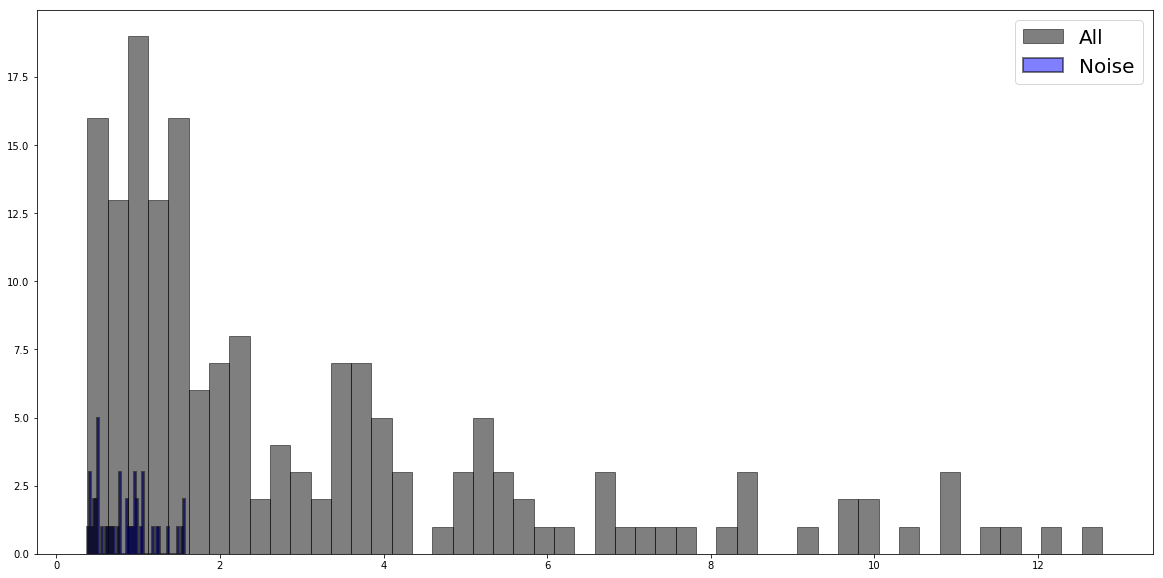

In [19]:
plt.figure(figsize=(20,10));
plt.hist(km,bins=50,color='black',alpha=0.5,edgecolor='black',label='All');
plt.hist(kevinsmethod0,bins=50,color='blue',alpha=0.5,edgecolor='black',linewidth=2,label='Noise');
plt.legend(loc='upper right',fontsize=20);

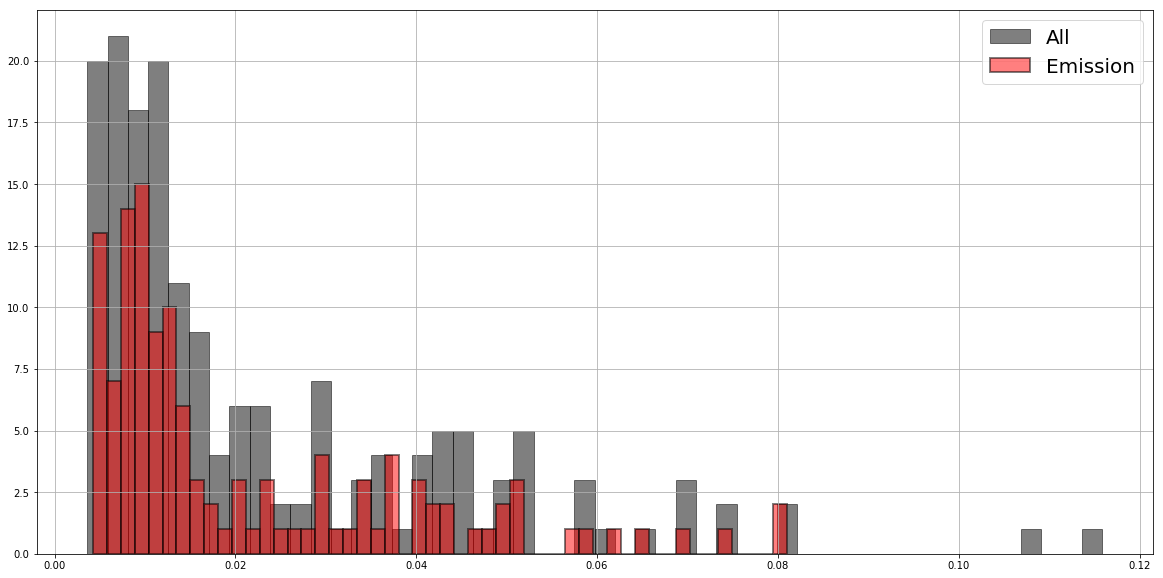

In [20]:
plt.figure(figsize=(20,10));
ebbets.hist(bins=50,edgecolor='black',color='black',alpha=0.5,label='All');
ebbets1.hist(bins=50,color='red',alpha=0.5,edgecolor='black',linewidth=2,label='Emission');
plt.legend(loc='upper right',fontsize=20);

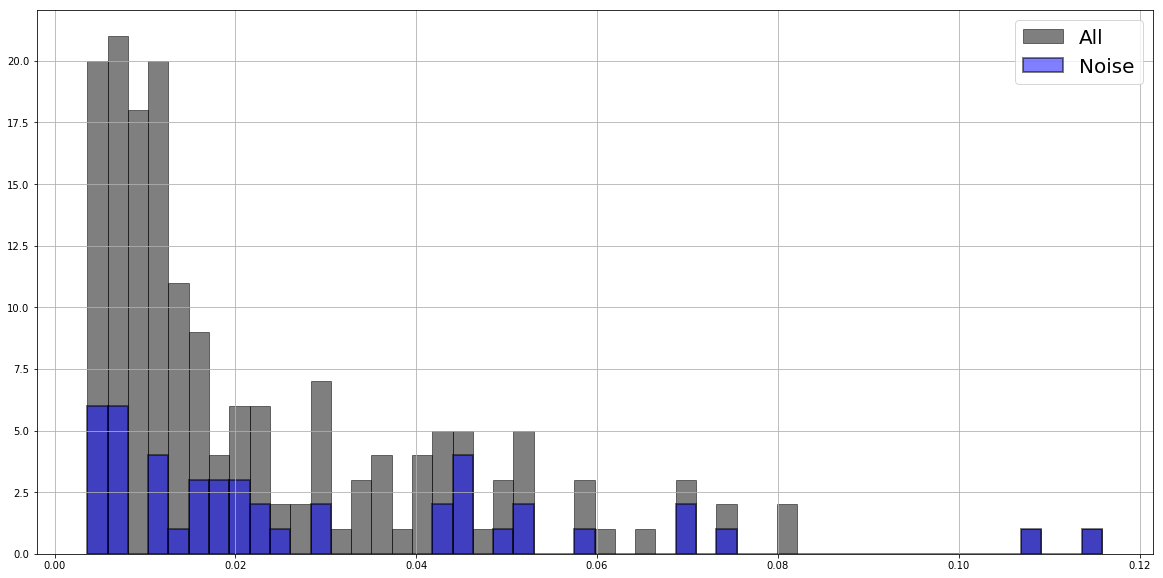

In [21]:
plt.figure(figsize=(20,10));
ebbets.hist(bins=50,color='black',edgecolor='black',alpha=0.5,label='All');
ebbets0.hist(bins=50,color='blue',alpha=0.5,edgecolor='black',linewidth=2,label='Noise');
plt.legend(loc='upper right',fontsize=20);

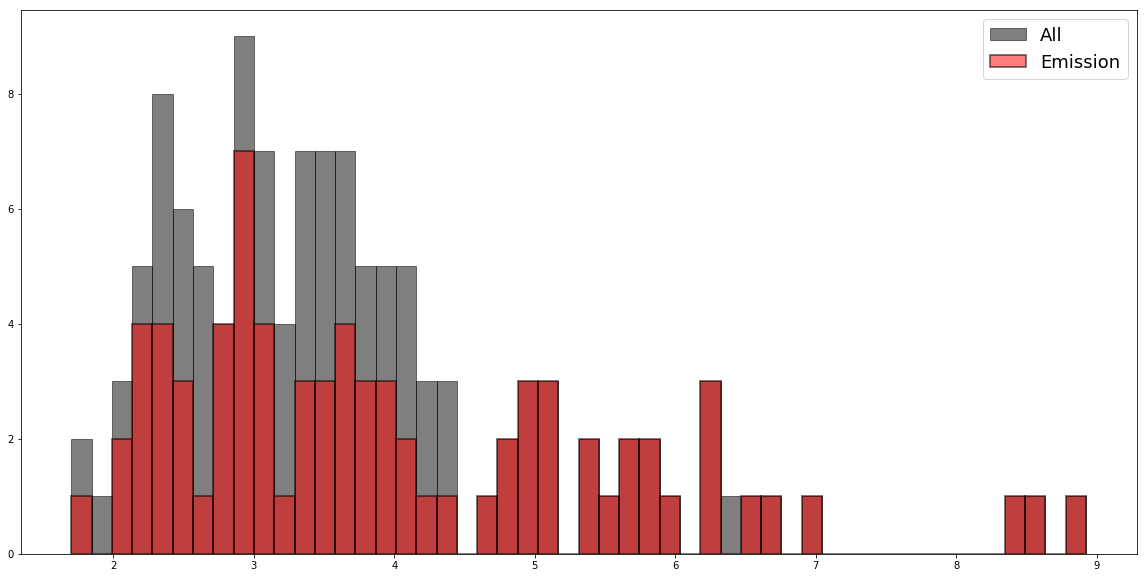

In [24]:
plt.figure(figsize=(20,10));
plt.hist(a,bins=50,color='black',alpha=0.5,edgecolor='black',label='All');
plt.hist(area1,bins=50,color='red',alpha=0.5,label='Emission',edgecolor='black',linewidth=2);
plt.legend(loc='upper right',fontsize=18);

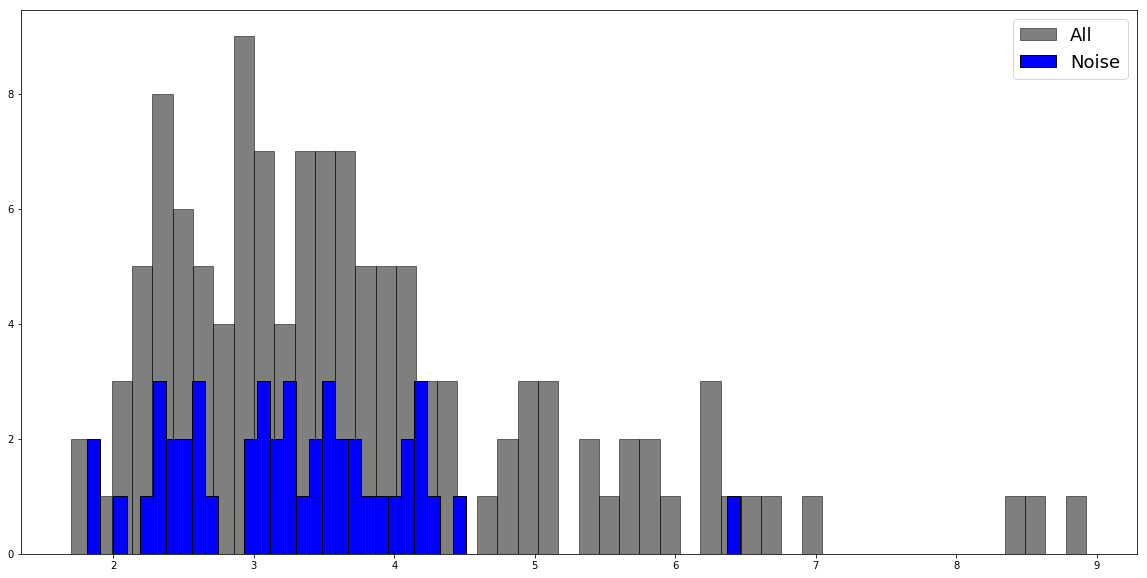

In [25]:
plt.figure(figsize=(20,10));
plt.hist(a,bins=50,color='black',alpha=0.5,edgecolor='black',label='All');
plt.hist(Area0,bins=50,color='blue',label='Noise',edgecolor='black');
plt.legend(loc='upper right',fontsize=18);